<a href="https://colab.research.google.com/github/YenLinWu/CRNN_with_CTC_Loss/blob/main/CRNN_with_CTC_in_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect Google Colab with Google Drive  連接 Colab 與 drive 

In [ ]:
from google.colab import drive
drive.mount( '/content/gdrive' )

# Import Packages  匯入套件

In [2]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt  
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Reshape, Bidirectional, LSTM
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

print( 'TensorFlow Version:', tf.__version__ )
print( 'Keras Version:', tf.keras.__version__ ) 

TensorFlow Version: 2.3.0
Keras Version: 2.4.0


# Captcha Images Dataset  驗證碼資料集

In [4]:
os.chdir( r"/content/gdrive/My Drive" )
if not os.path.isdir( r"CRNN_with_CTC_Loss" ):     
    print( 'Downloading the Captcha images dataset ...' )
    !pip install patool
    import patoolib
    import glob
    # Clone a GitHub repository to our Google Drive
    !git clone https://github.com/YenLinWu/CRNN_with_CTC_Loss.git     
    # Unzip a file with filename contains '.rar'
    rar = glob.glob( r"CRNN_with_CTC_Loss/*.rar" )
    patoolib.extract_archive( rar[0], outdir=r"/content/gdrive/My Drive" )

else: print( 'Captcha images dataset is ready.' )

Captcha images dataset is ready.


In [5]:
# Path to the dataset directory
CaptchaImages = r"/content/gdrive/My Drive/CaptchaImages"
data_dir = Path( CaptchaImages )

print( 'Working directory:', data_dir )

Working directory: /content/gdrive/My Drive/CaptchaImages


In [6]:
# Get list of all the captcha images
Images = sorted( list(map(str, list(data_dir.glob('*.png')))) )
Labels = [ img.split(os.path.sep)[-1].split(".png")[0] for img in Images ]
Characters = set( char for label in Labels for char in label )
Image_Height = set( tf.image.decode_png(tf.io.read_file(img_path)).shape[0] for img_path in Images )
Image_Width = set( tf.image.decode_png(tf.io.read_file(img_path)).shape[1] for img_path in Images )

# Maximum length of any captcha in the dataset
Max_Length = max([ len(label) for label in Labels ])

print( 'Number of images found: ', len(Images) )
print( 'Number of labels found: ', len(Labels), '\n' )
print( 'Width of any captcha image:', next(iter(Image_Width)) )
print( 'Height of any captcha image:', next(iter(Image_Height)) )
print( 'Characters present: ', Characters ) 
print( 'Number of unique characters: ', len(Characters) )
print( 'Maxium length of any captcha image: ', Max_Length )

Number of images found:  1800
Number of labels found:  1800 

Width of any captcha image: 104
Height of any captcha image: 24
Characters present:  {'9', '6', '4', '1', '8', '7', '3', '5', '0', '2'}
Number of unique characters:  10
Maxium length of any captcha image:  4


# Hyper-parameters  超參數

In [7]:
# Desired image dimensions where img_width % 4==0 and img_hight % 16==0 
img_width = 104
img_height = 32

# Number of passes of the entire training set the algorithm has completed
Epochs = 100

# Number of each batch
Batch_Size = 32

# Early Stopping
'''
min_delta: 容忍模型進步的最小幅度
patience: 容忍訓練無再進步時的 Epoch 次數
'''
Early_Stopping_Patience = 10 
Min_Delta = 0.0001

# Preprocessing  資料預處理

In [8]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
                  vocabulary=sorted(list(Characters)), num_oov_indices=0, mask_token=None )

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
                  vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True )

In [9]:
def encode_single_sample( img_path, label ):
    # 1. Read image
    img = tf.io.read_file( img_path )
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png( img, channels=1 )
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype( img, tf.float32 )
    # 4. Resize to the desired size
    img = tf.image.resize( img, [img_height,img_width] )
    # 5. Transpose the image because we want the time dimension to correspond to the width of the image, 
    #    i.e., shape = (img_weight,img_height,1).
    img = tf.transpose( img, perm=[1,0,2] )
    # 6. Map the characters in label to numbers
    label = char_to_num( tf.strings.unicode_split(label, input_encoding='UTF-8') )
    # 7. Return a dict as our model is expecting two inputs
    return { "image": img, "label": label }

# Training and Validation Sets  訓練集與驗證集

In [10]:
# Splitting dataset into training and validation sets
def split_data( Images, Labels, train_size=0.9, shuffle=True ):
    # 1. Get the total amount of the dataset
    size = len( Images )
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange( size )
    if shuffle:
        np.random.seed(42) 
        np.random.shuffle( indices )
    # 3. Get the size of training samples
    train_samples = int( size*train_size )
    # 4. Split data into training and validation sets
    x_train, y_train = Images[indices[:train_samples]], Labels[indices[:train_samples]]
    x_valid, y_valid = Images[indices[train_samples:]], Labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

x_train, x_valid, y_train, y_valid = split_data( np.array(Images), np.array(Labels) )

print( 'Number of training set:', len(x_train) )
print( 'Number of validation set:', len(x_valid) )

Number of training set: 1620
Number of validation set: 180


In [11]:
# Create training and valodation dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices( (x_train,y_train) )
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(Batch_Size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices( (x_valid,y_valid) )
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(Batch_Size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

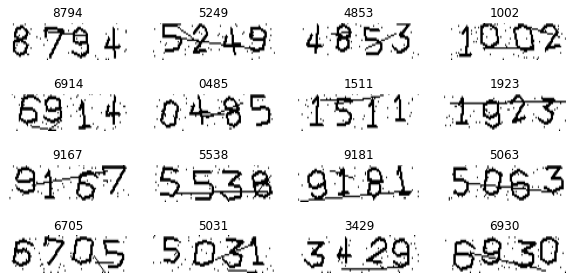

In [12]:
# Visualize the Training Dataset
_, ax = plt.subplots( 4, 4, figsize=(10,5) )
for batch in train_dataset.take(1):
    images = batch['image']
    labels = batch['label']
    for i in range(16):
        img = ( images[i]*255 ).numpy().astype('uint8')
        label = tf.strings.reduce_join( num_to_char(labels[i]) ).numpy().decode('utf-8')
        ax[i // 4, i % 4].imshow( img[:, :, 0].T, cmap='gray' )
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis('off')
plt.show()

# Convolutional Recurrent Neural Network(CRNN)  卷積循環神經網絡  

In [13]:
# Build an endpoint layer for implementing CTC loss.
class CTCLayer( layers.Layer ):
    def __init__( self, name=None, **kwargs ):
        super().__init__( name=name )
        self.loss_fn = K.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it to the layer using `self.add_loss()`.
        batch_len = tf.cast( tf.shape(y_true)[0], dtype='int64' )
        input_length = tf.cast( tf.shape(y_pred)[1], dtype='int64' )
        label_length = tf.cast( tf.shape(y_true)[1], dtype='int64' )
        
        input_length = input_length*tf.ones( shape=(batch_len,1), dtype='int64' )
        label_length = label_length*tf.ones( shape=(batch_len,1), dtype='int64' )

        loss = self.loss_fn( y_true, y_pred, input_length, label_length )
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [14]:
def Build_Model():
    # Inputs to the model 
    input_tensor = Input( (img_width,img_height,1), dtype='float32', name='Input' )
    labels = Input( shape=(None,), dtype='float32', name="Label" )
    
    # First convolution block
    x = Conv2D( 64, (3,3), activation='relu', padding='same', name='Conv_1' )(input_tensor)
    x = MaxPooling2D( pool_size=(2,2), strides=2, name='MaxPooling_1' )(x)
    
    # Second convolution block
    x = Conv2D( 128, (3,3), activation='relu', padding='same', name='Conv_2' )(x)
    x = MaxPooling2D( pool_size=(2,2), strides=2, name='MaxPooling_2' )(x)
    
    # Third convolution block
    x = Conv2D( 256, (3,3), activation='relu', padding='same', name='Conv_3' )(x)
    x = BatchNormalization( name='BN_1' )(x)
    
    # Fourth convolution block
    x = Conv2D( 512, (3,3), activation='relu', padding='same', name='Conv_4' )(x)  
    x = MaxPooling2D( pool_size=(2,1), strides=2, name='MaxPooling_3' )(x)
    
    # Fifth convolution block
    x = Conv2D( 512, (2,2), activation='relu', name='Conv_5' )(x)
    
    # Reshape accordingly before passing the output to the RNN part of the model,
    # i.e., convert shape=(batch,feature_weight,feature_height,channel) to shape=(batch,feature_weight,channel*feature_height) 
    Conv_Shape = x.get_shape( )
    x = Reshape( target_shape=(int(Conv_Shape[1]),int(Conv_Shape[2]*Conv_Shape[3])), name='Reshape' )(x)
    x = Dense( 64, activation='relu', name='Dense' )(x)
    x = Dropout( 0.25, name='Dropout' )(x)

    # RNNs
    x = Bidirectional( LSTM( 256, return_sequences=True, dropout=0.25 ), name='LSTM_1' )(x)
    x = Bidirectional( LSTM( 256, return_sequences=True, dropout=0.25 ), name='LSTM_2' )(x)

    # Output layer
    x = Dense( len(Characters)+1, activation='softmax', name='Softmax' )(x) 

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer( name='CTC_Loss' )(labels, x)
    
    # Define the model
    model = Model( inputs=[input_tensor,labels], outputs=[output], name='CRNN_Model_with_CTC_LOSS' )    
    
    # Compile the model and return
    model.compile( optimizer=Adam() )
    
    return model

CRNN = Build_Model()
CRNN.summary()

Model: "CRNN_Model_with_CTC_LOSS"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 104, 32, 1)] 0                                            
__________________________________________________________________________________________________
Conv_1 (Conv2D)                 (None, 104, 32, 64)  640         Input[0][0]                      
__________________________________________________________________________________________________
MaxPooling_1 (MaxPooling2D)     (None, 52, 16, 64)   0           Conv_1[0][0]                     
__________________________________________________________________________________________________
Conv_2 (Conv2D)                 (None, 52, 16, 128)  73856       MaxPooling_1[0][0]               
___________________________________________________________________________

# Callbacks  回調函數

In [15]:
# Model Check Point
Check_Point = ModelCheckpoint( 'CRNN.h5',   # Filepath
                               monitor='val_loss',
                               save_best_only=True,
                               verbose=1,
                               mode='auto',
                               save_weights_only=False,
                               save_freq='epoch' )

In [16]:
# Add early stopping
Early_Stopping = EarlyStopping( monitor='val_loss',
                                min_delta=Min_Delta,
                                patience=Early_Stopping_Patience,
                                verbose=1,
                                mode='auto',
                                baseline=None,
                                restore_best_weights=True )

# Training Model  訓練模型

In [17]:
History = CRNN.fit( train_dataset, validation_data=validation_dataset, epochs=Epochs, 
                    callbacks=[ Check_Point, Early_Stopping ] )                      

Epoch 1/100
51/51 [==============================] - ETA: 0s - loss: 11.1204
Epoch 00001: val_loss improved from inf to 10.80343, saving model to CRNN.h5
51/51 [==============================] - 5s 97ms/step - loss: 11.1204 - val_loss: 10.8034
Epoch 2/100
50/51 [============================>.] - ETA: 0s - loss: 10.6541
Epoch 00002: val_loss improved from 10.80343 to 10.78117, saving model to CRNN.h5
51/51 [==============================] - 4s 77ms/step - loss: 10.6547 - val_loss: 10.7812
Epoch 3/100
50/51 [============================>.] - ETA: 0s - loss: 10.6508
Epoch 00003: val_loss improved from 10.78117 to 10.76097, saving model to CRNN.h5
51/51 [==============================] - 4s 75ms/step - loss: 10.6512 - val_loss: 10.7610
Epoch 4/100
51/51 [==============================] - ETA: 0s - loss: 10.6319
Epoch 00004: val_loss improved from 10.76097 to 10.74905, saving model to CRNN.h5
51/51 [==============================] - 4s 72ms/step - loss: 10.6319 - val_loss: 10.7491
Epoch 5/1

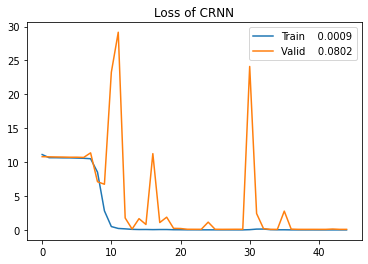

In [18]:
Train_Loss = History.history['loss']
Val_Loss = History.history['val_loss']
epochs_range = range(Epochs)

plt.subplot( )
plt.plot( range( len(Train_Loss) ), Train_Loss, label='Train'+"{:10.4f}".format( min(History.history['loss']) ) )
plt.plot( range( len(Val_Loss) ), Val_Loss, label='Valid'+"{:10.4f}".format( min(History.history['val_loss']) ) )
plt.legend( loc='upper right' )
plt.title( 'Loss of CRNN')
plt.show()

# Inference  預測

In [19]:
# Get the prediction model by extracting layers till the output layer
prediction_model = Model( CRNN.get_layer( name='Input' ).input, CRNN.get_layer( name='Softmax' ).output, name='Prediction' )
prediction_model.summary()

Model: "Prediction"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 104, 32, 1)]      0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 104, 32, 64)       640       
_________________________________________________________________
MaxPooling_1 (MaxPooling2D)  (None, 52, 16, 64)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 52, 16, 128)       73856     
_________________________________________________________________
MaxPooling_2 (MaxPooling2D)  (None, 26, 8, 128)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 26, 8, 256)        295168    
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 26, 8, 256)        1

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


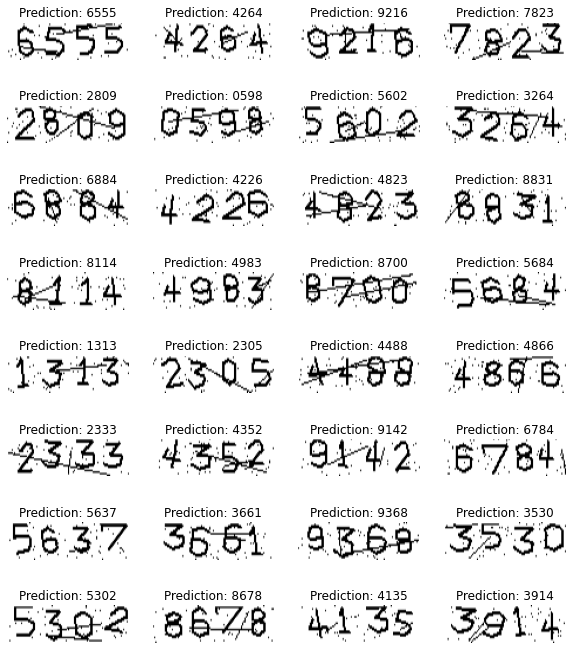

In [20]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = K.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:,:Max_Length]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode('utf-8')
        output_text.append(res)
    return output_text

#  Check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch['image']
    batch_labels = batch['label']

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode('utf-8')
        orig_texts.append(label)

    _, ax = plt.subplots( 8, 4, figsize=(10,12) )
    for i in range(len(pred_texts)):
        img = ( batch_images[i, :, :, 0]*255).numpy().astype(np.uint8)
        img = img.T
        title = f'Prediction: {pred_texts[i]}'
        ax[i // 4, i % 4].imshow( img, cmap='gray' )
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

# Programming Guides  程式語法指南     

> ## (1) Image Preprocessing  圖片預處理  

- ### [Module: tf.image](https://www.tensorflow.org/api_docs/python/tf/image)、[tf.image.convert_image_dtype](https://www.tensorflow.org/api_docs/python/tf/image/convert_image_dtype)、[tf.image.resize](https://www.tensorflow.org/api_docs/python/tf/image/resize)  
- ### [tf.io.read_file](https://www.tensorflow.org/api_docs/python/tf/io/read_file)、[tf.io.decode_png](https://www.tensorflow.org/api_docs/python/tf/io/decode_png)

> ## (2) Modeling  建模  
  
- ### [Making new layers and models via subclassing](https://keras.io/guides/making_new_layers_and_models_via_subclassing/)
- ### [tf.keras.layers.experimental.preprocessing.StringLookup](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/StringLookup)
- ### [tf.Tensor](https://www.tensorflow.org/api_docs/python/tf/Tensor)、[tf.reshape](https://www.tensorflow.org/api_docs/python/tf/reshape)、[tf.cast](https://www.tensorflow.org/api_docs/python/tf/cast)、[tf.nn.ctc_loss](https://www.tensorflow.org/api_docs/python/tf/nn/ctc_loss)、[tf.keras.backend.ctc_batch_cost](https://www.tensorflow.org/api_docs/python/tf/keras/backend/ctc_batch_cost)    

- ### [tf.keras.layers.Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)、[tf.keras.layers.MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)、[tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)、<br>[tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional)、[tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)

- ### [tf.keras.optimizers.Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)  
- ### [tf.keras.callbacks.ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)、[tf.keras.callbacks.EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)